In [7]:
import requests  
from bs4 import BeautifulSoup

import numpy as np   
import pandas as pd  
import time          

from tqdm import tqdm_notebook
import re

from fake_useragent import UserAgent

import socks
import socket
socks.set_default_proxy(socks.SOCKS5, "localhost", 9150)
socket.socket = socks.socksocket

In [ ]:
MAIN_LINK = "http://k.intimcity.nl/persons.php?index={}"
PERSON_LINK = "http://k.intimcity.nl/persons.php?id={}"

In [11]:
def checkIP():
    ip = requests.get('http://checkip.dyndns.org').content
    soup = BeautifulSoup(ip, 'html.parser')
    print(soup.find('body').text)

checkIP()

Current IP Address: 185.220.101.70


In [16]:
def get_soup(link):
    headers = {'User-Agent': UserAgent().chrome}
    response = requests.get(link, headers=headers)
    soup = BeautifulSoup(response.content, 'html.parser')
    return soup

In [17]:
def get_main_page(page_number, main_link=MAIN_LINK):
    main_page = get_soup(main_link.format(page_number))
    return main_page

In [18]:
def get_max_main_page(main_page):
    table = main_page.find('table', attrs={'style':'margin: auto; border-spacing: 3px;'})
    max_page = int(table.findAll('a', attrs={'class':'index'})[-2].text)
    return max_page

In [21]:
def get_persons_links(current_main_page, person_link=PERSON_LINK):
    persons_links = []
    page_ids = current_main_page.findAll('a', attrs={'class':'x'})
    for page_id in page_ids:
        page_id = re.findall(r'\d+', page_id.get('onclick'))[0]
        link = person_link.format(page_id)
        persons_links.append(link)
    return persons_links

In [355]:
def get_name(current_person_page):
    return {'name':current_person_page.find('h2').text}

In [424]:
def get_text_description(current_person_page):
    """Description written by seller"""
    description = current_person_page.find('td', attrs={'class':'ar13'})
    description = description.text if description else None
    return {'text_description': description}

In [331]:
def get_parameter_table(current_person_page):
    """All parameters (weight, height, address, etc.)"""
    parameter_table = current_person_page.find("table", attrs={'style':'width: 100%; border-spacing: 1px;'})
    parameter_table = pd.read_html(str(parameter_table))[0]
    parameter_table = parameter_table.set_index(0)
    parameter_table = parameter_table.to_dict()[1]
    return parameter_table

In [152]:
def get_prices_dict(current_person_page, flatten=True):
    """All prices (per hour, day/night, etc.)"""
    def _flatten_prices_dict(prices_dict):
        flattened_prices = {}
        for k, v in prices_dict.items():
            if isinstance(v, dict):
                for nested_k, nested_v in v.items():
                    if isinstance(nested_v, dict):
                        for nested_2_k, nested_2_v in nested_v.items():
                            flattened_prices["_".join([k, nested_k, nested_2_k])] = nested_2_v
                    else:
                        flattened_prices["_".join([k, nested_k])] = nested_v
            else:
                flattened_prices[k] = v
        return flattened_prices
    
    def _clean_number(df, row_index, col_index):
        try:
            string = df.iloc[row_index, col_index]
        except:
            return None
        try:
            return float("".join(re.findall(r'\d+', string)))
        except:
            return string
           
    prices = current_person_page.find(
        'table', 
        attrs={
            'style':'width: 440px; margin: 10px auto; background-color: #CCC; text-align: center; border-spacing: 1px;'
        }
    )
    prices = pd.read_html(str(prices))[0]
        
    prices_dict = {
        "апартаменты":{
            "днём": {
                "час": _clean_number(prices, 2, 1),
                "2часа": _clean_number(prices, 2, 2)
            },
            "ночью": {
                "час": _clean_number(prices, 2, 3),
                "2часа": _clean_number(prices, 2, 4)
            }
        },
        "выезд":{
            "днём": {
                "час": _clean_number(prices, 3, 1),
                "2часа": _clean_number(prices, 3, 2)
            },
            "ночью": {
                "час": _clean_number(prices, 3, 3),
                "2часа": _clean_number(prices, 3, 4)
            }
        },
        "контактов_в_час": _clean_number(prices, 4, 1),
        "анал": _clean_number(prices, 4, 4),
        "мбр": _clean_number(prices, 5, 4),
        "comments": _clean_number(prices, 6, 0)
    }
    
    if flatten:
        prices_dict = _flatten_prices_dict(prices_dict)
        
    return prices_dict

In [420]:
def get_services_dict(current_person_page):
    """Full list with services"""
    
    services = current_person_page.find("table", attrs={'style':'width: 100%; border-spacing: 5px;'})
    # boolean mask for cheked boxes
    services_bool = services.findAll('input', attrs={'type':'checkbox'})[:49]
    services_bool = [True if 'checked' in str(x) else False for x in services_bool]

    services_names = services.findAll('a')
    services_names = np.array([name.text for name in services_names])

    services_names = list(services_names[services_bool])
    return {'services':services_names, 'number_of_services':len(services_names)}

In [398]:
def get_photo_links(current_person_page):
    """Links to photos"""
    photo_links = current_person_page.find("div", attrs={'class':'highslide-gallery'})
    photo_links = photo_links.findAll('a')
    photo_links = [link.get("href") for link in photo_links]
    return {'photo_links':photo_links}

In [415]:
def get_checks_reviews(current_person_page):
    """Comments and reviews"""
    comments = current_person_page.find('div', attrs={'class':'noprint'}) 
    
    number_of_checks = comments.find('table', attrs={'style':'margin: auto;'})
    number_of_checks = len(number_of_checks.findAll('div', attrs={'class':'rnd5'})) if number_of_checks else 0
    # reviews from users
    reviews = comments.find('table', attrs={'style':'width: 440px; margin: 10px auto 0 auto;'})    
    reviews = reviews.findAll('div', attrs={'class':'rnd5'}) if reviews else []

    clean_reviews = []
    for review in reviews:
        span_tag = review.find('span')
        review_text = span_tag.next_sibling if span_tag else None
        try:
            clean_text = review_text.text
        except:
            clean_text = review_text
        if clean_text:
            clean_reviews.append(clean_text)
        
    number_of_reviews = len(clean_reviews)
    
    result = {
        'number_of_checks':number_of_checks,
        'number_of_reviews':number_of_reviews,
        'reviews_text':clean_reviews
    }
    return result

In [425]:
full_person_data = {}

name = get_name(current_person_page)
parameter_table = get_parameter_table(current_person_page)
text_description = get_text_description(current_person_page)
prices = get_prices_dict(current_person_page)
services = get_services_dict(current_person_page)
photo_links = get_photo_links(current_person_page)
checks_reviews = get_checks_reviews(current_person_page)

In [403]:
def get_full_person_data(current_person_page):
    """Wrapper for previous functions to collect full person data"""
    full_person_data = {}
    full_person_data.update(get_name(current_person_page))
    full_person_data.update(get_parameter_table(current_person_page))
    full_person_data.update(get_text_description(current_person_page))
    full_person_data.update(get_prices_dict(current_person_page))
    full_person_data.update(get_services_dict(current_person_page))
    full_person_data.update(get_photo_links(current_person_page))
    full_person_data.update(get_checks_reviews(current_person_page))
    return full_person_data

In [488]:
def main(save_intermediate=True):
    full_data = {}

    for page_number in tqdm_notebook(range(102), desc='main'):
        try:
            current_main_page = get_main_page(page_number)
            current_persons_links = get_persons_links(current_main_page)

            for person_link in tqdm_notebook(current_persons_links, desc='pages', leave=False):
                try:
                    current_person_page = get_soup(person_link)
                    full_person_data = get_full_person_data(current_person_page)
                    full_data[person_link] = full_person_data
                    #checkIP()
                except:
                    continue
                time.sleep(1)

        except Exception as e:
            print(e)
            continue
            
        if save_intermediate:
            pd.DataFrame(full_data).T.to_csv("full_data.csv")
    return pd.DataFrame(full_data).T

In [489]:
if __name__=="__main__":
    full_data = main()

In [491]:
full_data_df = pd.read_csv("full_data.csv", index_col=0)

In [492]:
full_data_df.head()

,comments,name,number_of_checks,number_of_reviews,number_of_services,photo_links,reviews_text,services,text_description,Вес,...,Девушка месяца - ИЮНЬ 2019,Девушка месяца - АПРЕЛЬ 2016,Девушка месяца - ИЮЛЬ 2017,Девушка месяца - МАРТ 2019,Девушка месяца - МАЙ 2019,Не старше,Девушка месяца - ДЕКАБРЬ 2012,Девушка месяца - АПРЕЛЬ 2018,Девушка месяца - ОКТЯБРЬ 2019,Девушка месяца - АВГУСТ 2018
http://k.intimcity.nl/persons.php?id=371255,NaN,Доминика,13,7,29,['https://intimka.nl/Persons_big/371255/131719...,"['Прекрасное создание, очень позитивное. Обяза...","['Секс классический', 'Секс групповой', 'Секс ...","Привет, мои уже любимые котики😍\r\nЯ впервые в...",60.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
http://k.intimcity.nl/persons.php?id=317771,2.0,Аня,7,0,11,['https://intimka.nl/Persons_big/317771/446734...,[],"['Секс классический', 'Секс анальный', 'Минет ...",Встречаюсь индивидуально. Фото мои. О ночных в...,58.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
http://k.intimcity.nl/persons.php?id=371399,NaN,Настя,3,0,20,['https://intimka.nl/Persons_big/371399/738083...,[],"['Секс классический', 'Секс анальный', 'Секс г...",Обожаю дарить удовольствие и хорошее настроени...,65.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
http://k.intimcity.nl/persons.php?id=372831,NaN,Оля,1,2,8,['https://intimka.nl/Persons_big/372831/347591...,"['Пробегал мимо, решил слить по быстрому. Норм...","['Секс классический', 'Минет в презервативе', ...",Экспресс 1000!!!,70.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
http://k.intimcity.nl/persons.php?id=369196,NaN,Лолита,8,5,30,['https://intimka.nl/Persons_big/369196/789671...,"['Excellent girl , never forgettable memories...","['Секс классический', 'Секс групповой', 'Секс ...",Всем привет! Никогда раньше не работала! Всё в...,55.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


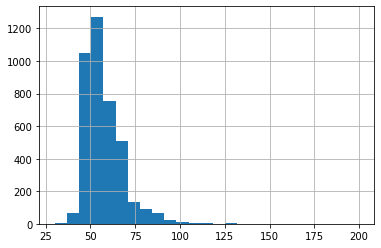

In [476]:
full_data_df['Вес'] = full_data_df['Вес'].astype(float)
full_data_df['Вес'].hist(bins=25)

In [493]:
full_data_df['Вес'].min(), full_data_df['Вес'].max()

(30.0, 200.0)

In [494]:
full_data_df[full_data_df["Вес"]==30]

,comments,name,number_of_checks,number_of_reviews,number_of_services,photo_links,reviews_text,services,text_description,Вес,...,Девушка месяца - ИЮНЬ 2019,Девушка месяца - АПРЕЛЬ 2016,Девушка месяца - ИЮЛЬ 2017,Девушка месяца - МАРТ 2019,Девушка месяца - МАЙ 2019,Не старше,Девушка месяца - ДЕКАБРЬ 2012,Девушка месяца - АПРЕЛЬ 2018,Девушка месяца - ОКТЯБРЬ 2019,Девушка месяца - АВГУСТ 2018
http://k.intimcity.nl/persons.php?id=291849,2.0,Полина,18,56,25,['https://intimka.nl/Persons_big/291849/509513...,['Был у этой девочки. Ну сказать что остался д...,"['Секс классический', 'Секс анальный', 'Секс г...","Мои обожаемые мужчины, пожалуйста договаривайт...",30.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [480]:
full_data_df[full_data_df["Вес"]==200]

,comments,name,number_of_checks,number_of_reviews,number_of_services,photo_links,reviews_text,services,text_description,Вес,...,Девушка месяца - ИЮНЬ 2019,Девушка месяца - АПРЕЛЬ 2016,Девушка месяца - ИЮЛЬ 2017,Девушка месяца - МАРТ 2019,Девушка месяца - МАЙ 2019,Не старше,Девушка месяца - ДЕКАБРЬ 2012,Девушка месяца - АПРЕЛЬ 2018,Девушка месяца - ОКТЯБРЬ 2019,Девушка месяца - АВГУСТ 2018
http://k.intimcity.nl/persons.php?id=366286,None,Елена,2,4,18,[https://intimka.nl/Persons_big/366286/1236369...,[Леночка супер в своём весе. А как она в сексе...,"[Секс классический, Минет в презервативе, Мине...",Супер Полная Дама! Жду в гости любителей супер...,200.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
